### Import Libraries

In [1]:
#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D #3d Plotting

#Geo-Visualisation
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cluster import MiniBatchKMeans, KMeans

### Helper Functions

In [2]:
# Source: 
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [3]:
#Kann raus oder?
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999 #nicht schön aber sollte funktionieren.
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

In [4]:
# Source: 
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

In [5]:
# Source: self-written
def moving_average(array,n):
    target = []
    rng = n / 2 - 0.5
    rng = int(rng)
    i = 0
    while i < len(array):
        value = 0
        if (i >= rng-1) & (i< len(array)-rng):
            value = sum(array[i-rng:i+rng+1])/n
        target.append(value)
        i = i + 1
    i = 0
    while i < rng:
        target[i] = target[rng]
        target[-i-1] = target[-rng-1]
        i = i + 1
        
    return target

________________________

# 1. Data Cleaning

## 1.1 Importing raw data
We import the given dataset. 

We also import self-gathered data:
- Daily information on whether the day was a national or regional holiday or whether there were school vacations
- Geo-coordinates for city centers of both cities
- SHP files for the cities including city districts

In [6]:
df_b = pd.read_csv("./dataset/bochum.csv")
df_l = pd.read_csv("./dataset/leipzig.csv")

In [7]:
#Self-gathered datasets that gives information about the relevant days
date_info_l = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_l["date"] = pd.to_datetime(date_info_l["date"],format="%d.%m.%Y").dt.date
date_info_l.index = date_info_l["date"]
date_info_l = date_info_l.drop(columns=["date"])

date_info_b = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_b["date"] = pd.to_datetime(date_info_b["date"],format="%d.%m.%Y").dt.date
date_info_b.index = date_info_b["date"]
date_info_b = date_info_b.drop(columns=["date"])

In [8]:
leipzig = {"lng": 12.3741468,"lat": 51.340744}
bochum = {"lng": 7.2164417,"lat": 51.4816637}

In [9]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system
bochum_map = gpd.read_file("./resources/bochum/Stadtbezirke.shp").to_crs(epsg=4326).rename(columns={"Stadtbezir":"Name"})

## 1.2 Looking for null values
We look for holes in the data. Note that, as data event-based and not continuous, we do not discover missing "events" (e.g. if there are no records for certain days).

In [10]:
print("Total number of null values:",
      (sum(df_l.isnull().sum())+sum(df_l.isnull().sum())))

Total number of null values: 0


## 1.3 Correcting Data Types

In [11]:
def correct_data_types(Nextbike):
    #Converting Trip Length to timedelta
    Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

    #Converting start-time to datetime
    Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
    Nextbike.drop(columns=['day','time'], inplace = True)

    #round coordinates to filter out gps unpreciseness
    cols = ["orig_lat","orig_lng","dest_lat","dest_lng"]
    Nextbike[cols] = Nextbike[cols].round(3)
    
    return Nextbike

df_l = correct_data_types(df_l)
df_b = correct_data_types(df_b)

## 1.4 Adding columns for analysis
We then proceed to calculate some useful columns that will help us analyse the dataset. While this might produce some columns that are not frequently used, we benefit from having all beneficial information ready for use.

To attempt to approximate the resulting revenue, we stick to the only pricing strategy that can be applied to the data that we have, which is 1€ per 30 minutes. Note that Nextbike offers a lot of different pricing strategies, including flat rates and free minutes for students. We do not have enough information to include these in our calculation - so the Revenue metric is very likely to be misrepresentative and has to be taken with a grain of salt.

In [12]:
def add_columns_analysis(Nextbike,date_info):
    Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

    Nextbike["date"] = Nextbike.timestamp.dt.date
    Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
    Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week
    
    Nextbike["trip_duration_minutes"] = Nextbike["trip_duration"].dt.total_seconds()/60

    Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
    Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

    Nextbike['Time_float'] = Nextbike['timestamp'].dt.time
    Nextbike['Time_float'] = Nextbike['Time_float'].astype(str).str[3:5].astype(float)/60 + Nextbike["Time"]
    
    #take trip duration in minutes, calculate 1€ per 30 minutes of usage
    Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)
      
        
    Nextbike=pd.merge(Nextbike,date_info,left_on="date",right_index=True)
    Nextbike["free"] = ((Nextbike["day_classifier"]=="weekend") | (Nextbike["holiday"]=="1"))
    
    return Nextbike


df_l = add_columns_analysis(df_l,date_info_l)
df_b = add_columns_analysis(df_b,date_info_b)

In [13]:
def calc_traveled_distance(df):
    distances = []
    for index, row in df.iterrows():
        distances.append(calculate_distance(row["orig_lng"], 
                                            row["orig_lat"],
                                            row["dest_lng"], 
                                            row["dest_lat"]))
    return distances

df_l["distance_traveled"]=calc_traveled_distance(df_l)
df_b["distance_traveled"] = calc_traveled_distance(df_b)
df_l

b_number     city   trip_duration  orig_lat  orig_lng  dest_lat  \
0          10900  leipzig 0 days 00:12:00    51.330    12.342    51.330   
1          10900  leipzig 0 days 00:08:00    51.330    12.342    51.330   
2          10900  leipzig 0 days 00:40:00    51.330    12.342    51.330   
3          10900  leipzig 0 days 00:03:00    51.330    12.342    51.330   
2788       20204  leipzig 0 days 00:13:00    51.333    12.404    51.339   
...          ...      ...             ...       ...       ...       ...   
171614     39065  leipzig 0 days 00:38:00    51.326    12.375    51.331   
171615     39065  leipzig 0 days 00:10:00    51.331    12.374    51.335   
171616     39065  leipzig 0 days 00:07:00    51.335    12.391    51.332   
171617     39065  leipzig 0 days 00:09:00    51.331    12.406    51.319   
171618     39065  leipzig 0 days 00:10:00    51.319    12.401    51.333   

        dest_lng           timestamp   timestamp_rounded        date  ...  \
0         12.342 2019-04-16 11:17:00 2019-04-16 11:00:00  2019-04-16  ...   
1         12.342 2019-04-16 11:35:00 2019-04-16 11:00:00  2019-04-16  ...   
2         12.342 2019-04-16 11:53:00 2019-04-16 11:00:00  2019-04-16  ...   
3         12.342 2019-04-16 14:35:00 2019-04-16 14:00:00  2019-04-16  ...   
2788      12.382 2019-04-16 05:52:00 2019-04-16 05:00:00  2019-04-16  ...   
...          ...                 ...                 ...         ...  ...   
171614    12.374 2019-03-27 15:06:00 2019-03-27 15:00:00  2019-03-27  ...   
171615    12.391 2019-03-27 16:28:00 2019-03-27 16:00:00  2019-03-27  ...   
171616    12.406 2019-03-27 17:09:00 2019-03-27 17:00:00  2019-03-27  ...   
171617    12.401 2019-03-27 18:00:00 2019-03-27 18:00:00  2019-03-27  ...   
171618    12.412 2019-03-27 20:59:00 2019-03-27 20:00:00  2019-03-27  ...   

        week  trip_duration_minutes  Time  Time_float  revenue  \
0         16                   12.0    11   11.283333      1.0   
1         16                    8.0    11   11.583333      1.0   
2         16                   40.0    11   11.883333      2.0   
3         16                    3.0    14   14.583333      1.0   
2788      16                   13.0     5    5.866667      1.0   
...      ...                    ...   ...         ...      ...   
171614    13                   38.0    15   15.100000      2.0   
171615    13                   10.0    16   16.466667      1.0   
171616    13                    7.0    17   17.150000      1.0   
171617    13                    9.0    18   18.000000      1.0   
171618    13                   10.0    20   20.983333      1.0   

        day_classifier vacations  holiday   free  distance_traveled  
0              weekday         0        0  False           0.000000  
1              weekday         0        0  False           0.000000  
2              weekday         0        0  False           0.000000  
3              weekday         0        0  False           0.000000  
2788           weekday         0        0  False           1.667600  
...                ...       ...      ...    ...                ...  
171614         weekday         0        0  False           0.560299  
171615         weekday         0        0  False           1.262030  
171616         weekday         0        0  False           1.094186  
171617         weekday         0        0  False           1.378829  
171618         weekday         0        0  False           1.734244  

[185327 rows x 21 columns]

## 1.5 Creating an array with all dates
This is just a simple array that contains all dates from the range of our data. It will help us in our analysis on some occasions.

In [14]:
start_date = df_l.date.min()
end_date = df_l.date.max()
delta = pd.to_timedelta("1d")
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
    
dates_df = pd.DataFrame(index=dates)

## 1.6 Filtering out unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area. We start by calculating the distances to the city centre for origin and destination. We then filter out rides that are way outside of the distribution of distance.

Text(0.5, 1.0, 'Bochum')

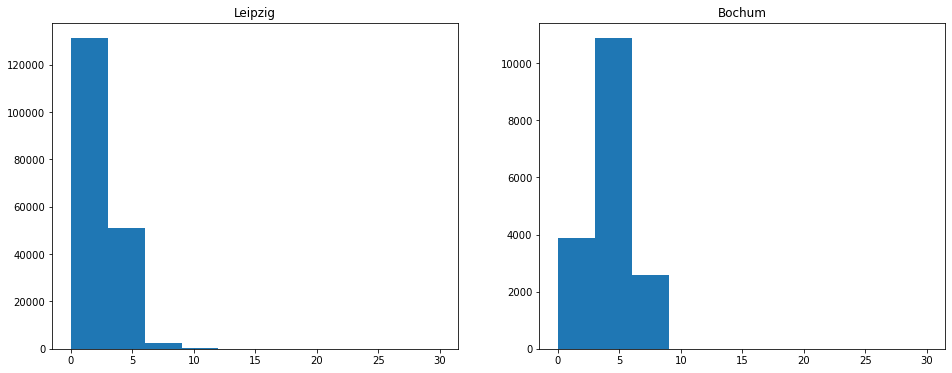

In [15]:
def add_distances_center(df,city):
    start_distance_center = []
    end_distance_center = []
    max_distance_center = []

    for index, row in df.iterrows():
        start = calculate_distance(lon1 = row["orig_lng"],
                               lat1 = row["orig_lat"],
                               lon2 = city["lng"],
                               lat2 = city["lat"])
        end = calculate_distance(lon1 = row["dest_lng"], 
                                lat1 = row["dest_lat"],
                                lon2 = city["lng"],
                                lat2 = city["lat"])
        if start > end:
            max = start
        else:
            max = end
        start_distance_center.append(start)
        end_distance_center.append(end)
        max_distance_center.append(max)

    df["start_distance_center"] = start_distance_center
    df["end_distance_center"] = end_distance_center
    df["max_distance_center"] = max_distance_center

    #df["max_distance_center"] = df["max_distance_center"].round()

    distances = df.groupby("max_distance_center").agg(
    count = ("b_number","count"))

    
add_distances_center(df_l,leipzig)
add_distances_center(df_b,bochum)

# Output
Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_l["max_distance_center"]
axes[0].hist(x,range=(0,30))
axes[0].set_title('Leipzig')

x = df_b["max_distance_center"]
axes[1].hist(x,range=(0,30))
axes[1].set_title('Bochum')

In [16]:
df_b

b_number    city   trip_duration  orig_lat  orig_lng  dest_lat  \
0           683  bochum 0 days 00:10:00    51.490     7.233    51.480   
153        4422  bochum 0 days 00:12:00    51.468     7.215    51.480   
154        4422  bochum 0 days 00:06:00    51.480     7.222    51.482   
155        4422  bochum 0 days 00:13:00    51.482     7.215    51.473   
297        7020  bochum 0 days 00:08:00    51.481     7.133    51.474   
...         ...     ...             ...       ...       ...       ...   
14445     53362  bochum 0 days 00:05:00    51.457     7.271    51.452   
15456     53567  bochum 0 days 00:08:00    51.478     7.207    51.480   
15877     53608  bochum 0 days 00:08:00    51.473     7.241    51.480   
16861     53863  bochum 0 days 00:09:00    51.453     7.246    51.448   
17024     53904  bochum 0 days 00:04:00    51.453     7.246    51.447   

       dest_lng           timestamp   timestamp_rounded        date  ...  \
0         7.222 2019-02-08 12:06:00 2019-02-08 12:00:00  2019-02-08  ...   
153       7.222 2019-02-08 10:53:00 2019-02-08 10:00:00  2019-02-08  ...   
154       7.215 2019-02-08 15:53:00 2019-02-08 15:00:00  2019-02-08  ...   
155       7.217 2019-02-08 21:14:00 2019-02-08 21:00:00  2019-02-08  ...   
297       7.139 2019-02-08 15:11:00 2019-02-08 15:00:00  2019-02-08  ...   
...         ...                 ...                 ...         ...  ...   
14445     7.273 2019-03-03 15:57:00 2019-03-03 15:00:00  2019-03-03  ...   
15456     7.222 2019-03-03 02:50:00 2019-03-03 02:00:00  2019-03-03  ...   
15877     7.222 2019-03-03 16:10:00 2019-03-03 16:00:00  2019-03-03  ...   
16861     7.234 2019-03-03 00:23:00 2019-03-03 00:00:00  2019-03-03  ...   
17024     7.245 2019-03-03 17:28:00 2019-03-03 17:00:00  2019-03-03  ...   

       Time_float  revenue  day_classifier  vacations  holiday   free  \
0       12.100000      1.0         weekday          0        0  False   
153     10.883333      1.0         weekday          0        0  False   
154     15.883333      1.0         weekday          0        0  False   
155     21.233333      1.0         weekday          0        0  False   
297     15.183333      1.0         weekday          0        0  False   
...           ...      ...             ...        ...      ...    ...   
14445   15.950000      1.0         weekend          0        0   True   
15456    2.833333      1.0         weekend          0        0   True   
15877   16.166667      1.0         weekend          0        0   True   
16861    0.383333      1.0         weekend          0        0   True   
17024   17.466667      1.0         weekend          0        0   True   

      distance_traveled  start_distance_center  end_distance_center  \
0              1.347806               1.474373             0.427058   
153            1.419687               1.522612             0.427058   
154            0.533325               0.427058             0.106609   
155            1.010294               0.106609             0.964135   
297            0.882335               5.778710             5.430437   
...                 ...                    ...                  ...   
14445          0.572985               4.669338             5.121451   
15456          1.062324               0.770376             0.427058   
15877          1.528842               1.954667             0.427058   
16861          1.000289               3.788257             3.935893   
17024          0.670759               3.788257             4.332498   

       max_distance_center  
0                 1.474373  
153               1.522612  
154               0.427058  
155               0.964135  
297               5.778710  
...                    ...  
14445             5.121451  
15456             0.770376  
15877             1.954667  
16861             3.935893  
17024             4.332498  

[17370 rows x 24 columns]

In [17]:
df_b.sort_values(by="max_distance_center",ascending=False)

b_number    city   trip_duration  orig_lat  orig_lng  dest_lat  \
1460      21314  bochum 0 days 00:03:00    50.931     6.917    50.931   
11008     52299  bochum 0 days 01:21:00    51.454     7.250    51.433   
14254     53324  bochum 0 days 00:52:00    51.433     7.126    51.427   
550        7037  bochum 0 days 00:14:00    51.433     7.126    51.427   
9376      51449  bochum 0 days 00:13:00    51.433     7.126    51.427   
...         ...     ...             ...       ...       ...       ...   
3237      50343  bochum 0 days 00:19:00    51.483     7.215    51.482   
16068     53639  bochum 0 days 00:41:00    51.482     7.215    51.483   
8448      51195  bochum 0 days 00:07:00    51.483     7.215    51.482   
17165     53947  bochum 0 days 00:07:00    51.483     7.215    51.482   
10891     52287  bochum 0 days 00:40:00    51.483     7.215    51.482   

       dest_lng           timestamp   timestamp_rounded        date  ...  \
1460      6.917 2019-04-26 13:50:00 2019-04-26 13:00:00  2019-04-26  ...   
11008     7.126 2019-03-29 15:49:00 2019-03-29 15:00:00  2019-03-29  ...   
14254     7.143 2019-05-17 14:16:00 2019-05-17 14:00:00  2019-05-17  ...   
550       7.143 2019-06-21 13:24:00 2019-06-21 13:00:00  2019-06-21  ...   
9376      7.143 2019-06-06 13:56:00 2019-06-06 13:00:00  2019-06-06  ...   
...         ...                 ...                 ...         ...  ...   
3237      7.215 2019-06-19 10:06:00 2019-06-19 10:00:00  2019-06-19  ...   
16068     7.215 2019-04-23 20:04:00 2019-04-23 20:00:00  2019-04-23  ...   
8448      7.215 2019-02-18 12:50:00 2019-02-18 12:00:00  2019-02-18  ...   
17165     7.215 2019-05-07 15:59:00 2019-05-07 15:00:00  2019-05-07  ...   
10891     7.215 2019-06-28 10:13:00 2019-06-28 10:00:00  2019-06-28  ...   

       Time_float  revenue  day_classifier  vacations  holiday   free  \
1460    13.833333      1.0         weekday          1        0  False   
11008   15.816667      3.0         weekday          0        0  False   
14254   14.266667      2.0         weekday          0        0  False   
550     13.400000      1.0         weekday          0        0  False   
9376    13.933333      1.0         weekday          0        0  False   
...           ...      ...             ...        ...      ...    ...   
3237    10.100000      1.0         weekday          0        0  False   
16068   20.066667      2.0         weekday          1        0  False   
8448    12.833333      1.0         weekday          1        0  False   
17165   15.983333      1.0         weekday          0        0  False   
10891   10.216667      2.0         weekday          0        0  False   

      distance_traveled  start_distance_center  end_distance_center  \
1460           0.000000              64.686855            64.686855   
11008          8.905563               3.855612             8.279300   
14254          1.354292               8.279300             7.927265   
550            1.354292               8.279300             7.927265   
9376           1.354292               8.279300             7.927265   
...                 ...                    ...                  ...   
3237           0.111195               0.179013             0.106609   
16068          0.111195               0.106609             0.179013   
8448           0.111195               0.179013             0.106609   
17165          0.111195               0.179013             0.106609   
10891          0.111195               0.179013             0.106609   

       max_distance_center  
1460             64.686855  
11008             8.279300  
14254             8.279300  
550               8.279300  
9376              8.279300  
...                    ...  
3237              0.179013  
16068             0.179013  
8448              0.179013  
17165             0.179013  
10891             0.179013  

[17370 rows x 24 columns]

In [18]:
df_l = df_l[df_l["max_distance_center"]<=15]
df_b = df_b[df_b["max_distance_center"]<=10]

## 1.7 Calculate Size of the Fleet
As in our opinion, the total number of available bikes plays a major role in KPIs (e.g. amount of rides per available bikes), but is also a relevant feature for predicting bike demand (we suspect more available bikes per km2 --> more attractive to rent a bike), we feel it is vital to know how the size of the fleet in the respective city changes over time.

Unfortunately, this data is not available in our dataset and thus has to be approximated through logics.

Our idea is to first get a feel about how much time (maximally) lies between rides with one specific bike. If we, for example, know that bikes never go over 7 days of not being used, we can count the number of unique bike IDs that were ridden at least once in the last 7 days to approximate the fleet size for a given date.

Text(0.5, 1.0, 'Bochum')

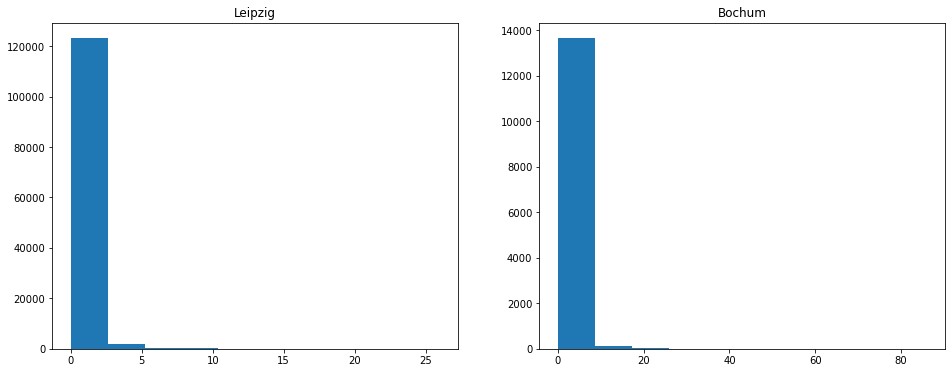

In [19]:
def stood_time(df):
    
    dfx = df.copy()[["b_number","timestamp","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng"]]
    dfx["timestamp_end"] = dfx["timestamp"] + dfx["trip_duration"]
    
    events = []
    
    for number in dfx["b_number"].unique():
        dfi = dfx[dfx["b_number"]==number].sort_values(by="timestamp")
        i = 0
        for index,row in dfi.iterrows():
            i = i + 1
            if i > 1:
                status = "moved"
                if [row["orig_lat"],row["orig_lng"]] == last_dest:
                    status = "stood"

                d = {
                    "b_number": number,
                    "from": last_timestamp,
                    "to": row["timestamp"],
                    "status": status
                }
                events.append(d)
            last_timestamp = row["timestamp_end"]
            last_dest = [row["dest_lat"],row["dest_lng"]]

    events = pd.DataFrame(events)
    events["length"] = events["to"] - events["from"]
    events["length_days"] = events["length"].dt.total_seconds() / (60* 60* 24)
    events["length_days"] = events["length_days"].round()
    
    return events[events["status"]=="stood"]
    

stood_l = stood_time(df_l)
stood_b = stood_time(df_b)

# Output
Fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = stood_l["length_days"]
axes[0].hist(x)
axes[0].set_title('Leipzig')

x = stood_b["length_days"]
axes[1].hist(x)
axes[1].set_title('Bochum')

We see that for Leipzig, most time deltas between rides seem to be from 0 to 3 days, with some ranging up to 10. Bochum shows a similar distribution, although there is a visible amount up to arount 20. We choose our calculation parameter accordingly.

Note that this is a balancing act: If we choose this number to high, we will include bikes that are not really in use anymore. If we choose it too small, we might not include bikes that are still active but were simply not used for a longer amount of time.

In [20]:
def fleet_size(df,factor):
    
    fleet_size = pd.DataFrame([], index = dates, columns = ["fleet_size"]) 

    search_array = []
    values = []
    for index, row in fleet_size.iterrows():
        search_array.append(index)
        if len(search_array) > factor:
            search_array.pop(0)
        values.append(df[df["date"].isin(search_array[:])].b_number.nunique())
        
    i = 0
    
    #Erklärung hierfür
    correction = values[factor-1]
    while i < factor-1:
        values[i] = correction
        i = i + 1
    fleet_size["fleet_size"] = values
    
    return fleet_size

fleet_size_l = fleet_size(df_l,10)
fleet_size_b = fleet_size(df_b,20)

## 1.8 Creating per-day DataFrame
This is as multi-purpose DataFrame that aggregates our rides to Dates. It contains all information that can be expressed on a date level.

In [21]:
def df_by_date(df,fleet_size):
    df_by_date = df.groupby("date").agg(
        week = ("week","min"),
        weekday = ("weekday","min"),
        daily_revenue=('revenue', "sum"),
        daily_trips=("b_number","count"),
        free = ("free","min"),
        daily_avg_length = ("trip_duration_minutes","mean"),
        daily_used_bikes=('b_number', pd.Series.nunique))

    df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
    df_by_date_merged["daily_usage"] = df_by_date_merged["daily_used_bikes"] / df_by_date_merged["fleet_size"]

    
    return df_by_date_merged


df_date_l = df_by_date(df_l,fleet_size_l)
df_date_b = df_by_date(df_b,fleet_size_b)

In [22]:
def add_trips_week(df):
    df_week = df.groupby("week").agg(weekly_trips=("daily_trips","sum"))
    return pd.merge(df,df_week,left_on="week",right_index=True,how="left")

In [23]:
df_date_l = add_trips_week(df_date_l)
df_date_l["weekly_relative_trips"] = df_date_l["daily_trips"] / df_date_l["weekly_trips"]
df_date_b = add_trips_week(df_date_b)
df_date_b["weekly_relative_trips"] = df_date_b["daily_trips"] / df_date_b["weekly_trips"]

## Creating per-hour DataFrame
This DataFrame is the core of the project as most of the analyses rely on hourly data. It contains all useful hour-level data, and it contains all day-level data such as fleet size, day classifiers etc. While daily data is now stored reduntantly both in the per-day and the per-hour DataFrame, it makes it most usable for analysis. Because our number of features and instances are of manageable size, this is not a problem.

In [24]:
def df_by_hour(df,df_date):

    df_by_hour = df.groupby("timestamp_rounded").agg(
        revenue=('revenue', "sum"),
        trips=("b_number","count"),
        date=("date","min"),
        time = ("Time","min"),
        avg_length = ("trip_duration_minutes","mean"),
        weekday=("weekday","min"),
        used_bikes=('b_number', pd.Series.nunique))


    df_by_hour_merged = pd.merge(df_by_hour, df_date, right_index=True, left_on='date')


    df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
    df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]
    
    return df_by_hour_merged


df_hour_l = df_by_hour(df_l, df_date_l)
df_hour_b = df_by_hour(df_b, df_date_b)

___________________________________

# 2. Descriptive Analytics

## 2.1 KPIs

### 2.1.1 Correcting Data

Our dataset has missing data on three days, in both cities. While this does not have any effect on clustering and regression operations, it does leave a hole when plotting daily KPIs and rental patterns (when dates are on the x axis). Thus we have to fill these holes for these analyses. 

In [25]:
from datetime import datetime, timedelta
df_kpi_l = df_date_l.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]
df_kpi_b = df_date_b.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]

def add_missing_days(df_kpi,dates,days):
    newdf = df_kpi.copy()
    df_missingdays = pd.merge(dates,df_kpi,left_index=True,right_index=True,how="left").isnull()
    df_missingdays = df_missingdays[df_missingdays["fleet_size"]==True]
    
    for day in df_missingdays.index:
        copyrow = df_kpi[df_kpi.index == (day + timedelta(days=days))]
        copyrow.index = copyrow.index - timedelta(days=days)
        newdf=newdf.append(copyrow)
    newdf=newdf.sort_index()
    return newdf

df_kpi_l= add_missing_days(df_kpi_l,dates_df,-7)
df_kpi_b= add_missing_days(df_kpi_b,dates_df,-7)

We then proceed to add our KPIs to our DataFrames. We also apply a moving average conversion to smooth out our data. We do this for better visibility of trends and differences between the respective cities.

### 2.1.2 Calculating KPIs

In [26]:
def add_kpis(df_kpi):
    df_kpi["trips_per_bike"] = df_kpi["daily_trips"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_bike"] = df_kpi["daily_revenue"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_trip"] = df_kpi["daily_revenue"]/df_kpi["daily_trips"]

    
    df_kpi["trips_per_bike_ma"] = moving_average(df_kpi["trips_per_bike"],7)
    df_kpi["revenue_per_bike_ma"] = moving_average(df_kpi["revenue_per_bike"],7)
    df_kpi["revenue_per_trip_ma"] = moving_average(df_kpi["revenue_per_trip"],7)
    
    df_kpi["daily_trips_ma"] =  moving_average(df_kpi["daily_trips"],7)
    df_kpi["daily_avg_length_ma"] = moving_average(df_kpi["daily_avg_length"],7)


add_kpis(df_kpi_l)
add_kpis(df_kpi_b)

### 2.1.3 Plotting KPIs

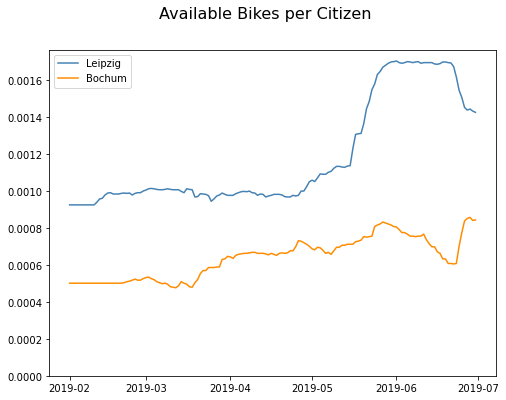

In [37]:
fig,axis = plt.subplots(1,1,figsize=(8,6))

_=axis.plot(df_kpi_l.index,(df_kpi_l["fleet_size"]/560472),c="steelblue",label = "Leipzig") #Citizens Leipzig
_=axis.plot(df_kpi_b.index,(df_kpi_b["fleet_size"]/364742),c="darkorange",label = "Bochum") #Citizens Bochum

axis.set_ylim(bottom=0)
axis.legend()
_=fig.suptitle("Available Bikes per Citizen", fontsize=16)

plt.savefig('./Exports/KPIs/Bikes_per_citizen.png', bbox_inches='tight')

In [38]:
def plot_kpis(df_kpi_l,df_kpi_b,kpi_name,title):
    fig,axis = plt.subplots(1,1,figsize=(8,6))
    
    axis.plot(df_kpi_l.index, df_kpi_l[kpi_name],c="steelblue",alpha = 0.3)
    axis.plot(df_kpi_l.index, df_kpi_l[kpi_name+"_ma"],c="steelblue",label="Leipzig")
    
    axis.plot(df_kpi_b.index,df_kpi_b[kpi_name],c="darkorange",alpha=0.3)
    axis.plot(df_kpi_b.index,df_kpi_b[kpi_name+"_ma"],c="darkorange",label="Bochum")
    
    axis.set_ylim(bottom=0)
    axis.legend()
    fig.suptitle(title, fontsize=16)

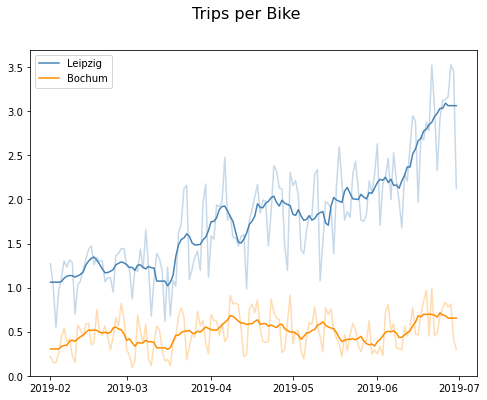

In [40]:
plot_kpis(df_kpi_l,df_kpi_b,"trips_per_bike","Trips per Bike")
plt.savefig('./Exports/KPIs/Trips_per_bike.png', bbox_inches='tight')

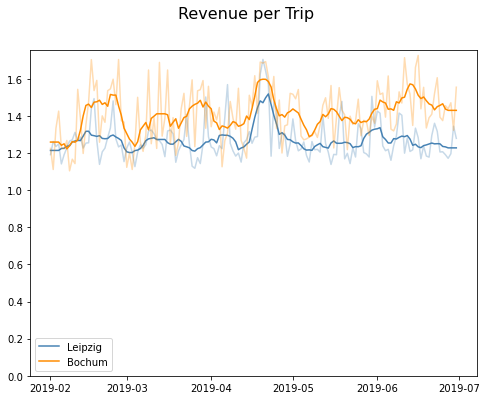

In [41]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_trip","Revenue per Trip")
plt.savefig('./Exports/KPIs/Revenue_per_trip.png', bbox_inches='tight')

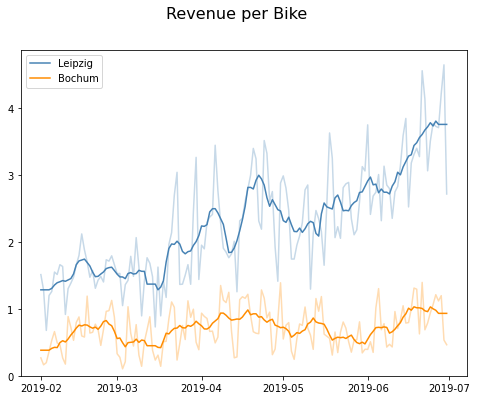

In [42]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_bike","Revenue per Bike")
plt.savefig('./Exports/KPIs/Revenue_per_bike.png', bbox_inches='tight')

_______________________________

## 2.2 Rental Patterns

### 2.2.1 Patterns in Amount of Trips

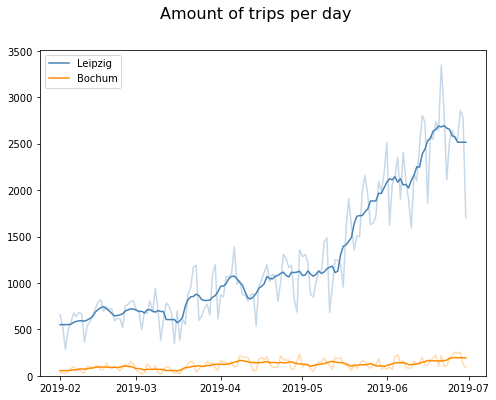

In [43]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_trips","Amount of trips per day")
#plt.savefig('./Exports/Rental-Patterns/trips_total.png', bbox_inches='tight')

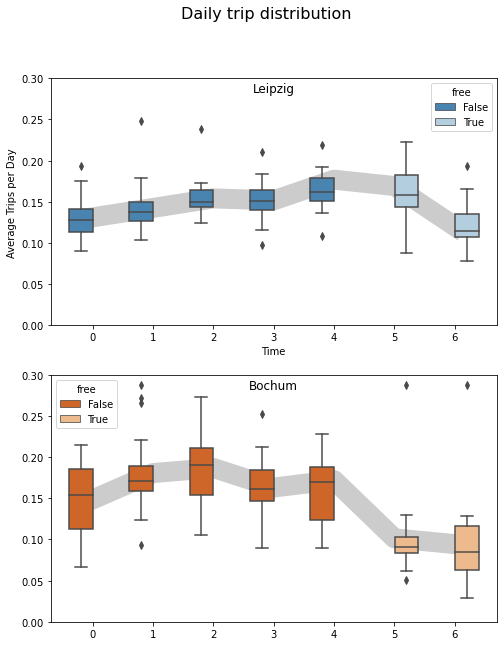

In [100]:
weekly_trend_l = df_date_l[["weekday","free","weekly_relative_trips"]]
weekly_trend_b = df_date_b[["weekday","free","weekly_relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="weekly_relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("weekly_relative_trips","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.3))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trips per Day')
axes[0].set_xlabel('Weekday')

plt.savefig('./Exports/Rental-Patterns/trips_weekly.png', bbox_inches='tight')

### Hourly Trip distribution

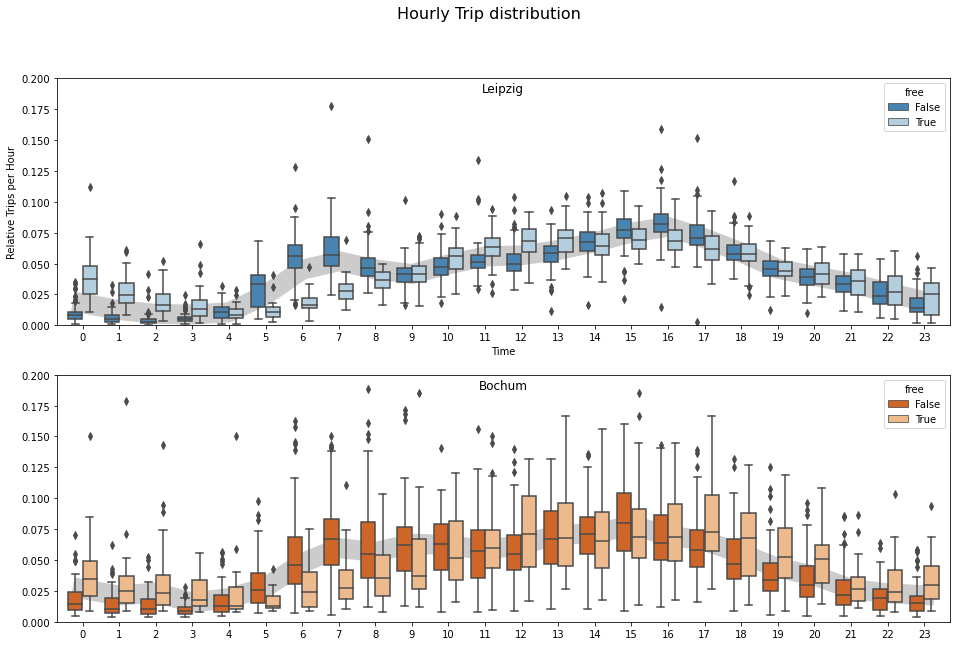

In [101]:
daily_trend_l = df_hour_l[["time","free","relative_trips"]]
daily_trend_b = df_hour_b[["time","free","relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Hourly Trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("relative_trips","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.2))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Relative Trips per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/trips_daily.png', bbox_inches='tight')

### 2.2.1 Patterns in Length of Trips

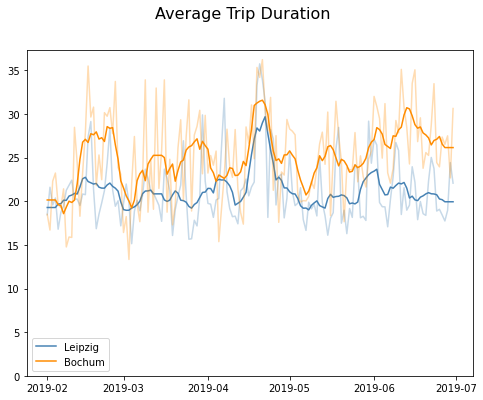

In [44]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_avg_length","Average Trip Duration")


plt.savefig('./Exports/Rental-Patterns/duration_total.png', bbox_inches='tight')

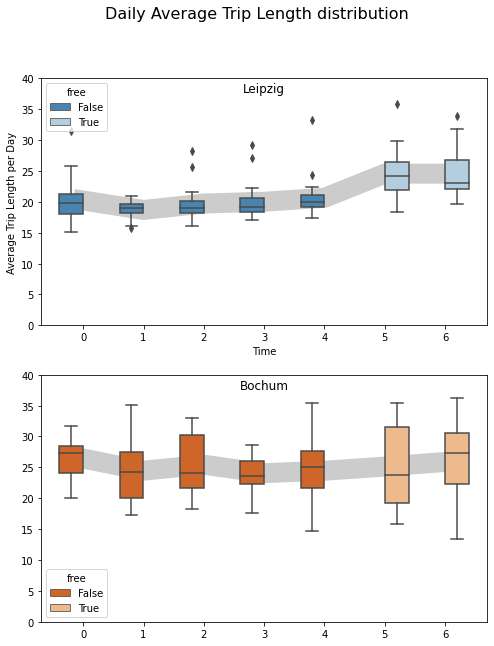

In [105]:
weekly_trend_l = df_date_l[["weekday","free","daily_avg_length"]]
weekly_trend_b = df_date_b[["weekday","free","daily_avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily Average Trip Length distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="daily_avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("daily_avg_length","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 40))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Day')
axes[0].set_xlabel('Weekday')

plt.savefig('./Exports/Rental-Patterns/duration_weekly.png', bbox_inches='tight')

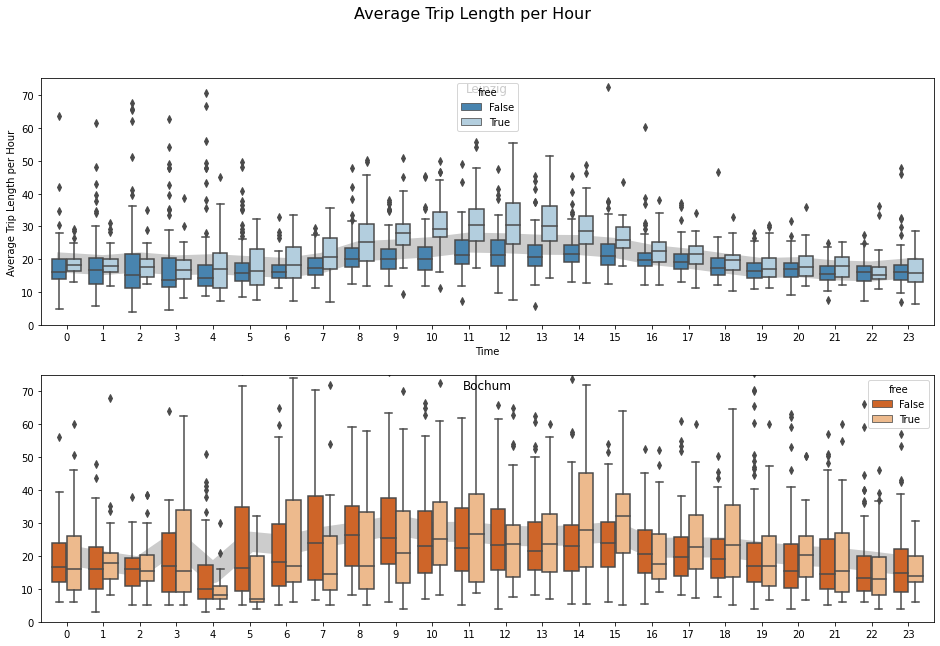

In [106]:
daily_trend_l = df_hour_l[["time","free","avg_length"]]
daily_trend_b = df_hour_b[["time","free","avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Average Trip Length per Hour', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("avg_length","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 75))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/duration_daily.png', bbox_inches='tight')

### 2.2.3 Geographic Rental Patterns
In this step, we plot the distribution of start and end locations of bike rentals in respect to the area. In order to reduce complexity, we focus on working days for now. We expect to see clearer patterns as we know from above that rental pattern differs between working and non-working days.

#### 2.2.3.1 Adding Area Names from Geographic Data

In [108]:
def area_array(df,polys,lng,lat):
    
    gdf = gpd.GeoDataFrame(df[[lng,lat]], geometry=gpd.points_from_xy(df[lng], df[lat]))
    
    stadtteile = []

    for index,row in gdf.iterrows():
        point = row["geometry"]
        stadtteil = None
        
        for indox,rew in polys.iterrows():
            if point.within(rew["geometry"]):
                stadtteil = rew["Name"]
                break
                
        stadtteile.append(stadtteil)
       
    return stadtteile

In [109]:
df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")
df_b["start_area"] = area_array(df_b,bochum_map,"orig_lng","orig_lat")
df_b["end_area"] = area_array(df_b,bochum_map,"dest_lng","dest_lat")

<ipython-input-109-67c0c91518ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
<ipython-input-109-67c0c91518ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")


#### 2.2.3.1 Plotting Relative Amount of Trips started by area and part of the day

In [112]:
def plot_sliced_days(df,polys,slices,titlecity):
    slice_size = 24/slices
    fig, axes = plt.subplots(2, slices, figsize=(30,20))
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    i=0
    while i < slices:
        min_time = slice_size*i
        max_time = min_time + slice_size - 1
        dfx = df[(df["Time"]>=min_time)&(df["Time"]<=max_time)]  # filter out only weekdays

        plottable_start = dfx.groupby("start_area").agg(count = ("start_area","count"))
        plottable_start = pd.merge(polys, plottable_start, left_on="Name", right_index=True)
        
        plottable_end = dfx.groupby("end_area").agg(count = ("end_area","count"))
        plottable_end = pd.merge(polys, plottable_end, left_on="Name", right_index=True)
            
        plottable_start.plot(ax=axes[0,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[0,i],crs=4326)
        polys.plot(ax=axes[0,i],zorder=3,alpha=0)
        axes[0,i].set_title('Start, '+str(min_time)+"h to " + str(max_time) + "h")
        
        plottable_end.plot(ax=axes[1,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[1,i],crs=4326)
        polys.plot(ax=axes[1,i],zorder=3,alpha=0)
        axes[1,i].set_title('End, '+str(min_time)+"h to " + str(max_time) + "h")
        i = i + 1
    
    ylim1,ylim2 = axes[0,0].get_ylim()
    xlim1,xlim2 = axes[0,0].get_xlim()

    for axis in axes[0]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)
    for axis in axes[1]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)

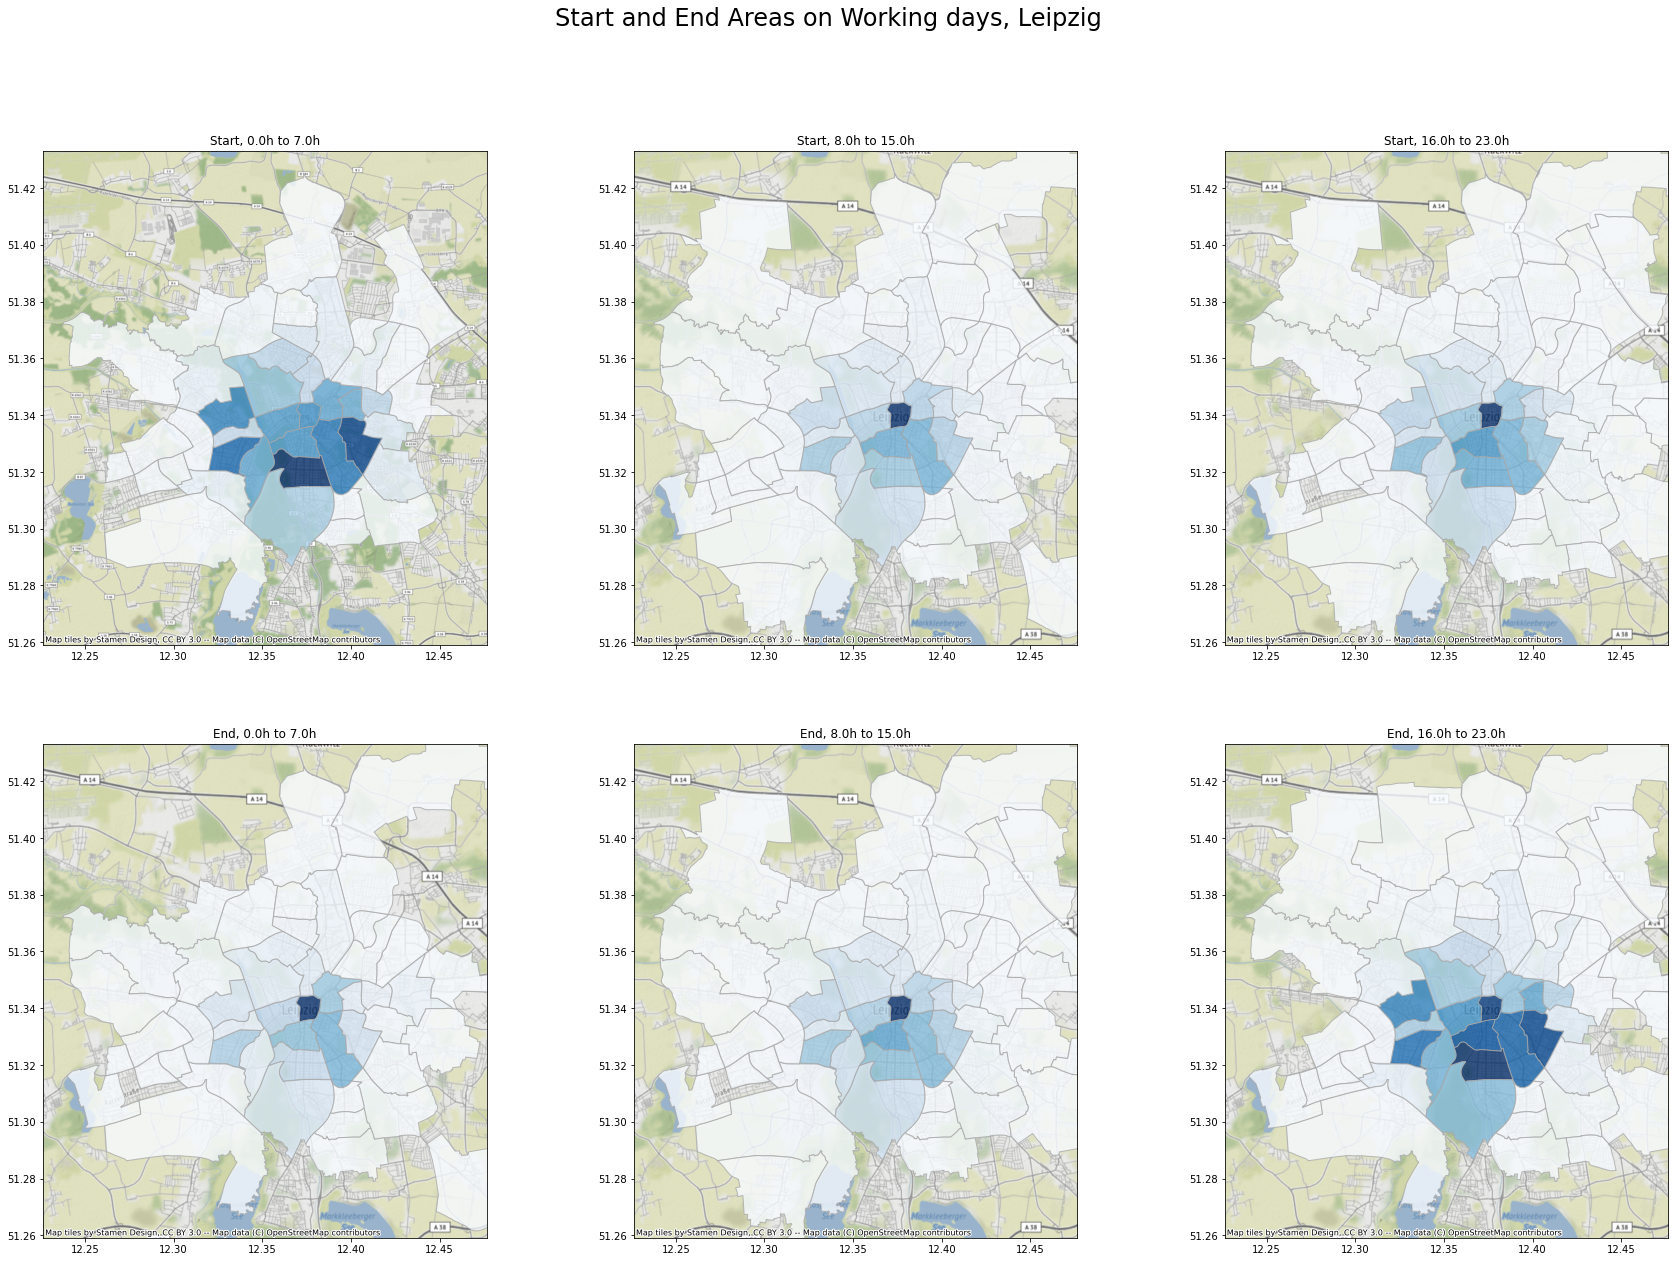

In [113]:
plot_sliced_days(df=df_l[df_l["free"]==False],polys=leipzig_map,slices=3,titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_areas_leipzig.png', bbox_inches='tight')


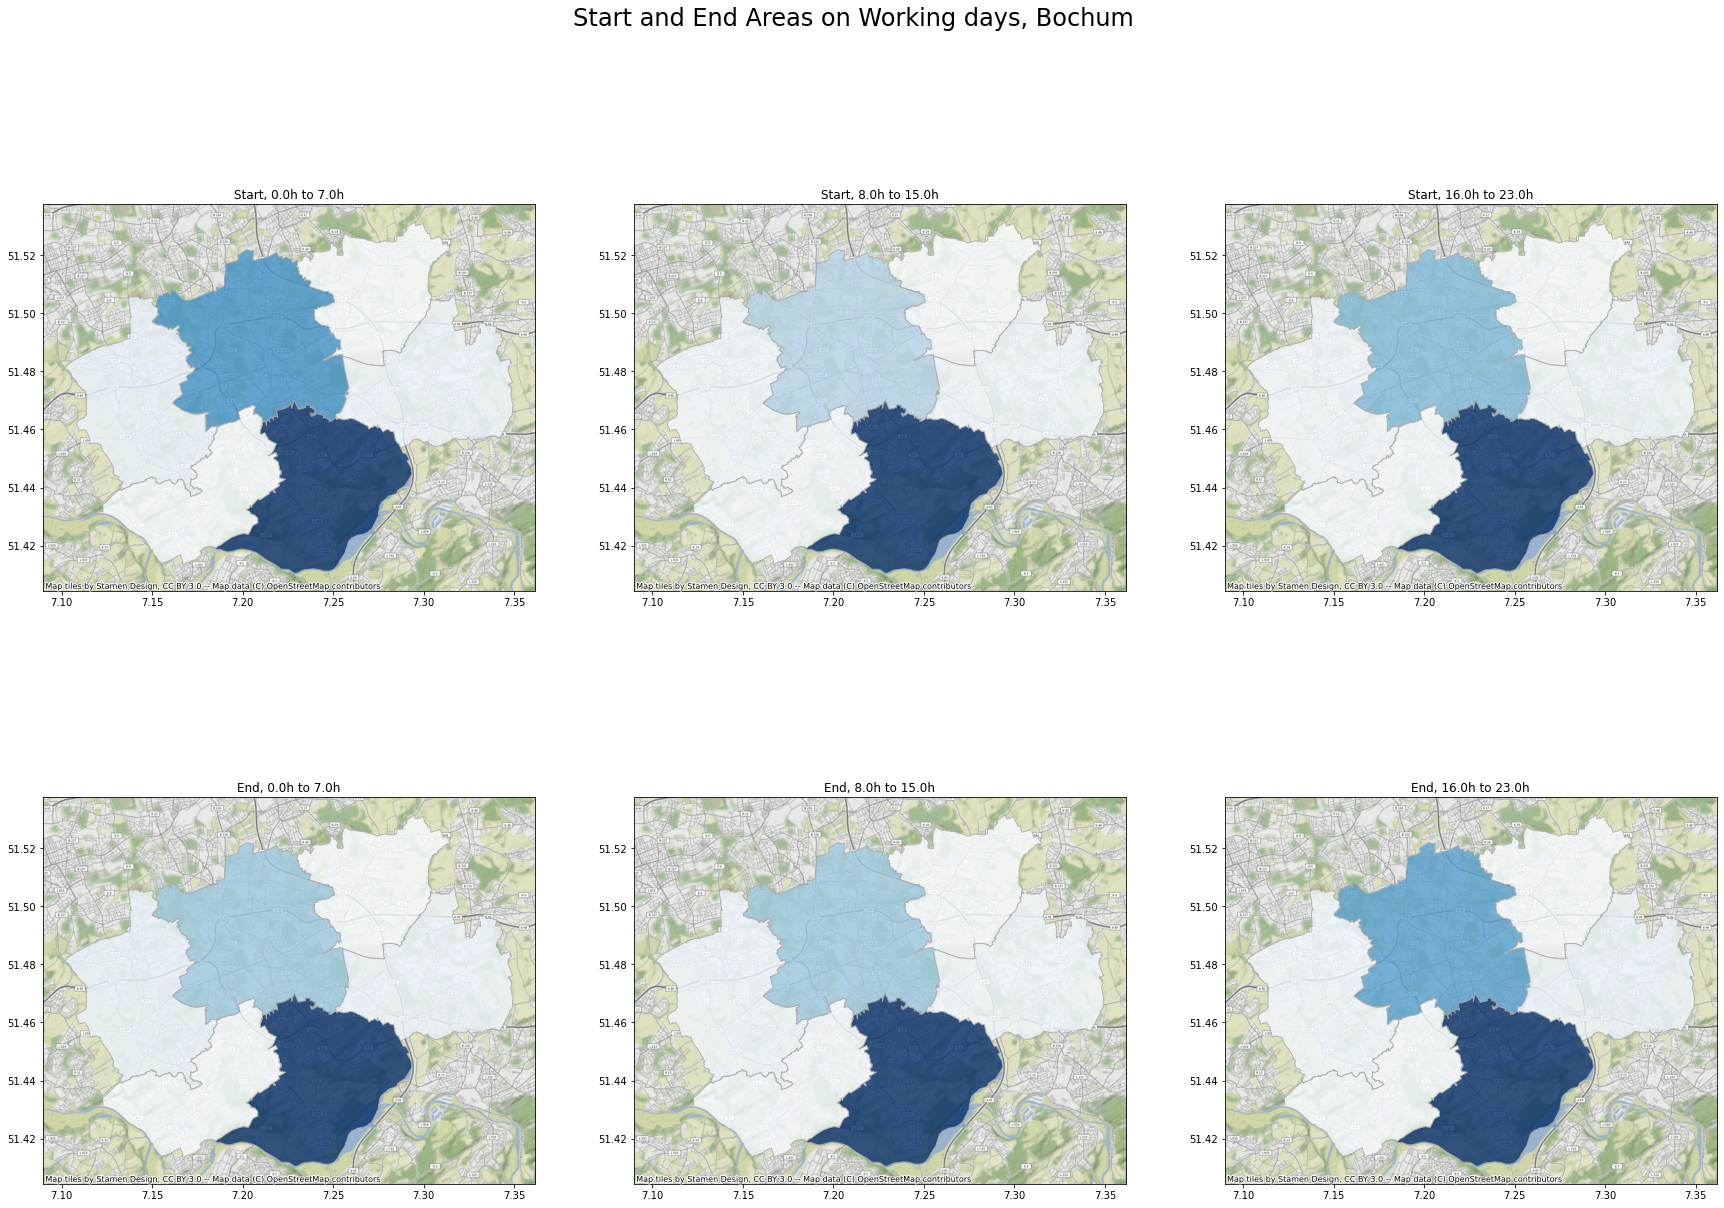

In [114]:
plot_sliced_days(df=df_b[df_b["free"]==False],polys=bochum_map,slices=3,titlecity="Bochum")

plt.savefig('./Exports/Rental-Patterns/geo_areas_bochum.png', bbox_inches='tight')


While the outcomes for Leipzig are quite detailed and allow for the conclusion that Nextbikes bikes are used to commute into the city in the morning and from the city in the evening, the area segments in the available Bochum map material seem to be too large to see such clear rental patterns. 

To solve this, we used KDE plotting from the Seaborn Library to produce a Heatmap-like Histogram that shows the same patterns without aggregating data to the respective areas.

#### 2.2.3.2 Plotting Relative Amount of Trips started by part of the day - Heatmap approach

In [174]:
def plot_locs_split(df,polys,splits,zoom,figsize,titlecity):
    slice_size = 24/splits
    fig, axes = plt.subplots(2,splits,figsize=figsize)
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    
    polys.plot(ax=axes[0,0],zorder=1,alpha=0)

    xlim1,xlim2 = axes[0,0].get_xlim()
    ylim1,ylim2 = axes[0,0].get_ylim()
    
    xmid = xlim1+(xlim2-xlim1)/2
    ymid = ylim1+(ylim2-ylim1)/2
 
    
    #zoom feature
    xlim1 = xmid + (xlim1-xmid)/zoom
    xlim2 = xmid + (xlim2-xmid)/zoom
    ylim1 = ymid + (ylim1-ymid)/zoom
    ylim2 = ymid + (ylim2-ymid)/zoom


    i = 0
    while i < splits:

        min_time = i*slice_size
        max_time = (i+1)*slice_size - 1
        df_split = df[(df["Time"]>=min_time) & (df["Time"]<=max_time)] # filter for specific quarter of day

        u=0
        while u<2:
            polys.plot(ax=axes[u,i],zorder=1,alpha=0)
            # Plotting the KDE Plot as a heatmap


            lng = "orig_lng"
            lat = "orig_lat"
            if u ==1:
                lng = "dest_lng"
                lat = "dest_lat"

            sns.kdeplot(x=df_split[lng],
                        y=df_split[lat],
                        shade=True,
                        thresh=0.1,
                        cmap="hot",
                        ax=axes[u,i]) 

            ctx.add_basemap(ax=axes[u,i],crs=4326,alpha=0.8)
            polys.plot(ax=axes[u,i],zorder=1,facecolor="none", edgecolor="black")

            axes[u,i].set_ylim(ylim1,ylim2)
            axes[u,i].set_xlim(xlim1,xlim2)
            
            axes[u,i].set_axis_off()
            
            u = u + 1
        
        axes[0,i].set_title(str(int(min_time))+" to "+str(int(max_time))+" O'Clock")

        i = i + 1



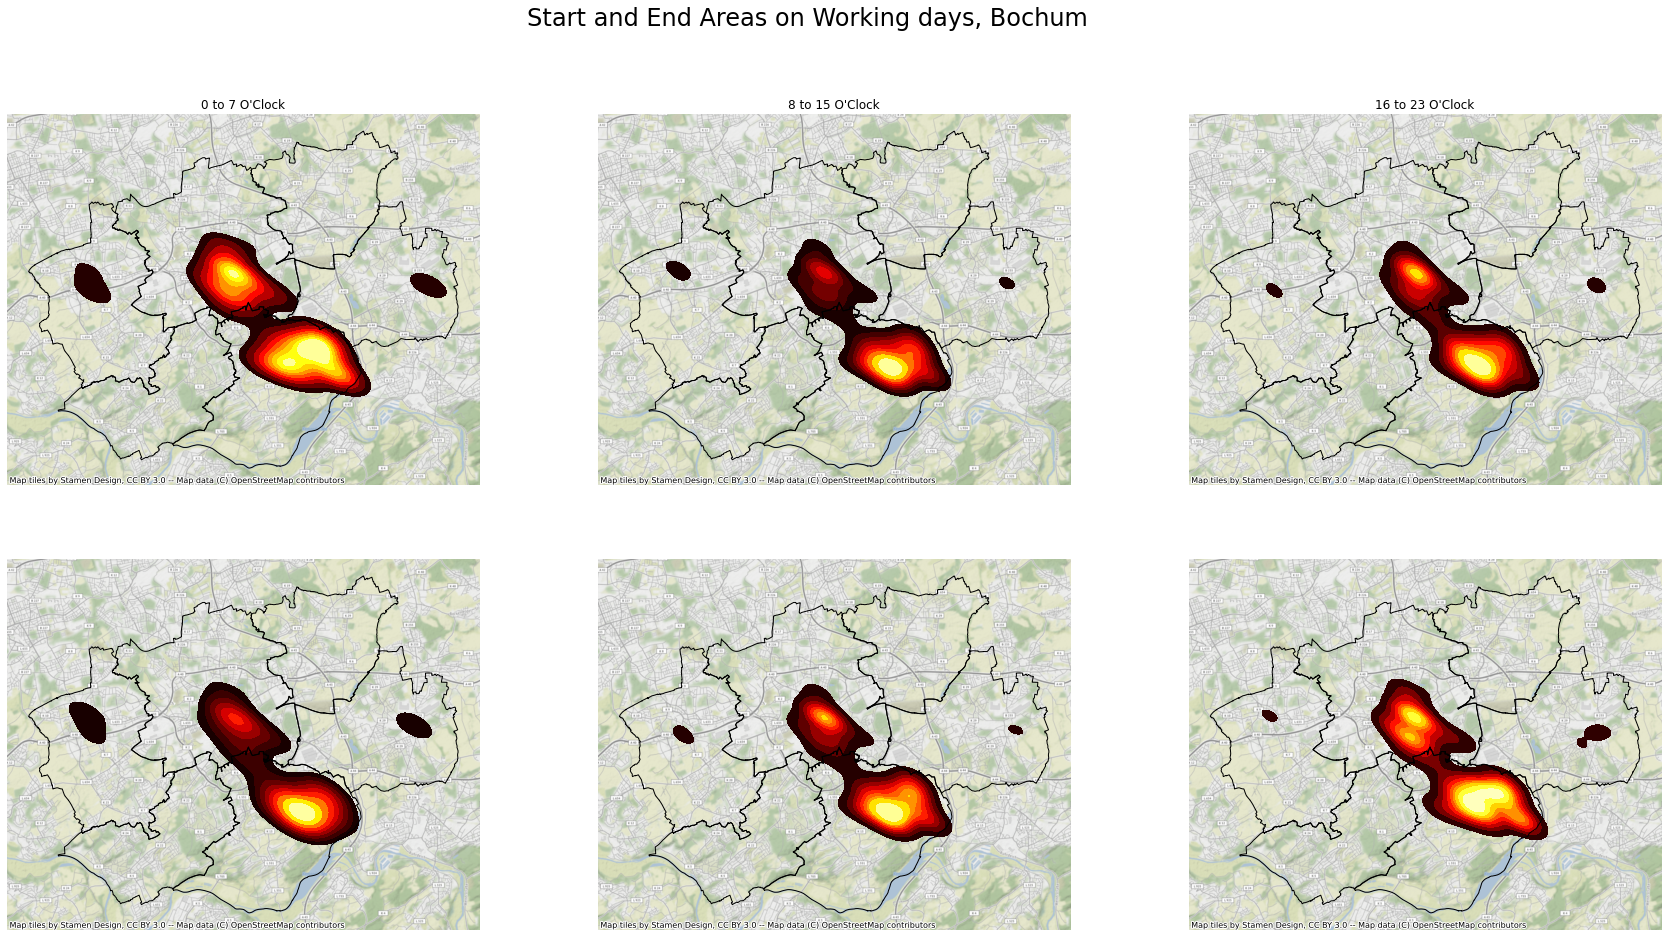

In [175]:
plot_locs_split(df=df_b[df_b["free"]==False],polys=bochum_map,splits=3,zoom=1,figsize=(30,15),titlecity="Bochum") 

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_bochum.png', bbox_inches='tight')

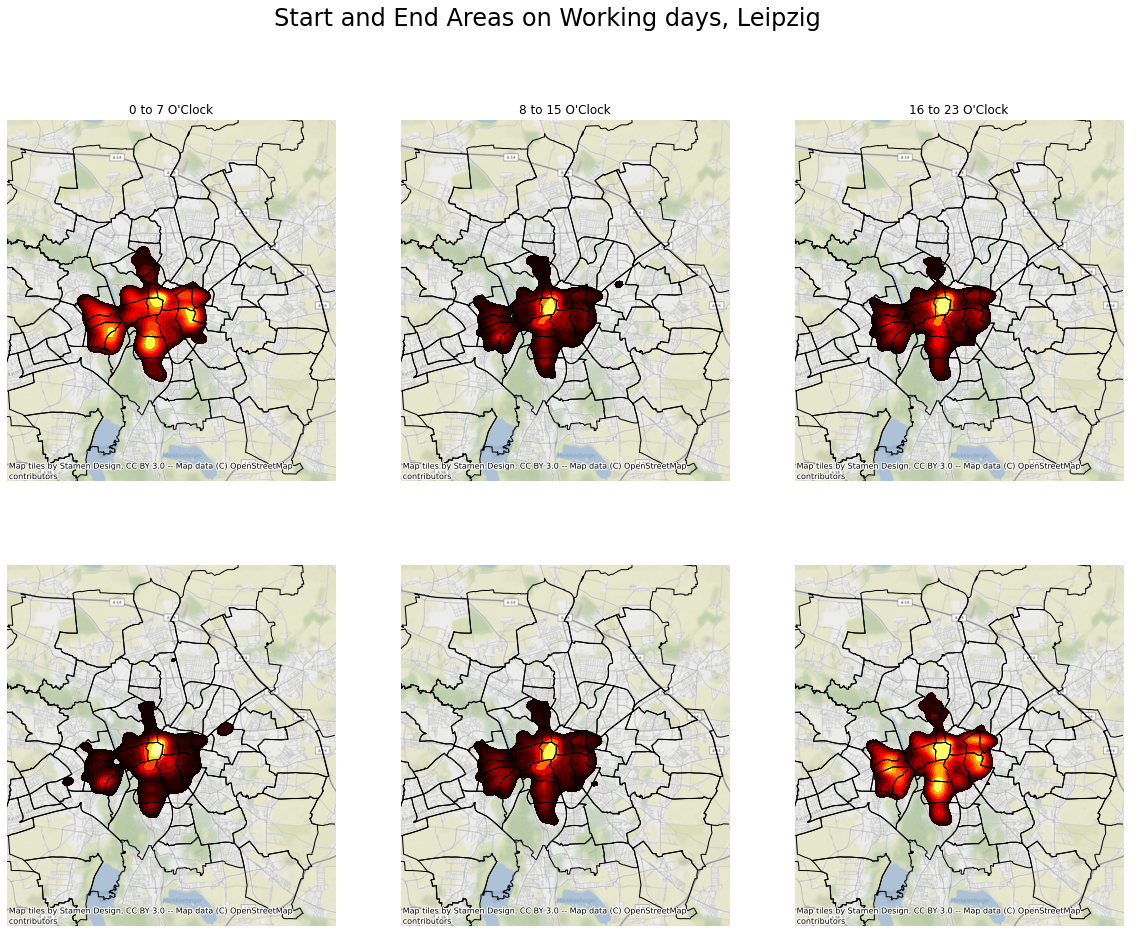

In [176]:
plot_locs_split(df=df_l[df_l["free"]==False],polys=leipzig_map,splits=3,zoom=1.3,figsize=(20,15),titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_leipzig.png', bbox_inches='tight')

____

# 3. Clustering

## 3.1 Preparing Dataset

In [117]:
df_clustering_b = df_b[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration_minutes",
                        "free",
                       "start_distance_center"]]
df_clustering_b_free = df_clustering_b[df_clustering_b["free"]==True]
df_clustering_b_work = df_clustering_b[df_clustering_b["free"]==False]

df_clustering_l = df_l[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration_minutes",
                        "free",
                        "start_distance_center"]]

df_clustering_l_free = df_clustering_l[df_clustering_l["free"]==True]
df_clustering_l_work = df_clustering_l[df_clustering_l["free"]==False]

## 3.2 Location based Clustering
Based on the insight from geographical rental patterns, we try to derive meaningful clusters of customers from our data. Our approach is to look at start locations on working days and build types of customers based on when they start their rides where. Based on our prior analysis, we would for example expect a concentration of start locations towards the city centre in Leipzig.

In [196]:
def location_clustering_3d(df_clustering,n,lng,lat,title):
    
    df_clustering= df_clustering[["Time_float",lng,lat]]
    fig = plt.figure(figsize =(10,12))
    fig.suptitle(title,fontsize=12)
    axis1 = fig.add_axes([0, 1, 0.2, 0.1]) # main axes
    axis2 = fig.add_axes([0, 1, 1, 1],projection='3d') # added axes
    #axis1 = fig.add_subplot()
    #axis2 = fig.add_subplot(projection='3d')
    
    df_clustering_n = min_max_scaling(df_clustering)

    ssd = []
    
    for i in range(2, 15):
        km = MiniBatchKMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)

    ssd=pd.DataFrame(ssd)
    ssd.columns = ["ssd"]

    axis1.plot(ssd)
    
    
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)

    
    
    _ = axis2.scatter(df_clustering["Time_float"],
                      df_clustering[lng],
                      df_clustering[lat],
                      s = 2,
                      c=labels,
                      alpha=1)

    axis2.invert_xaxis()
    
    plt.show()

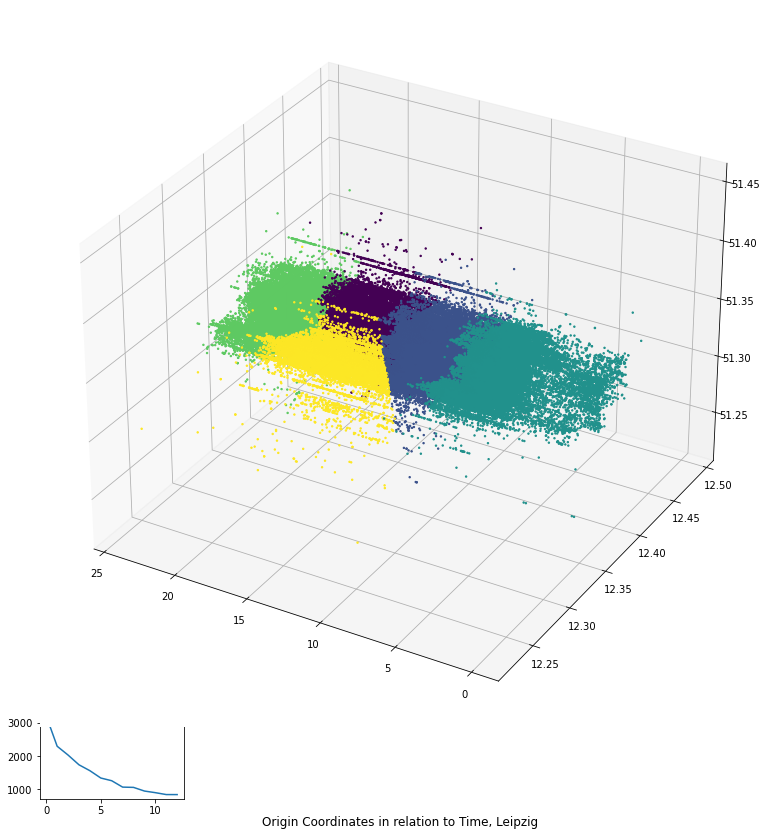

In [197]:
location_clustering_3d(df_clustering_l_work,5,"orig_lng","orig_lat","Origin Coordinates in relation to Time, Leipzig")

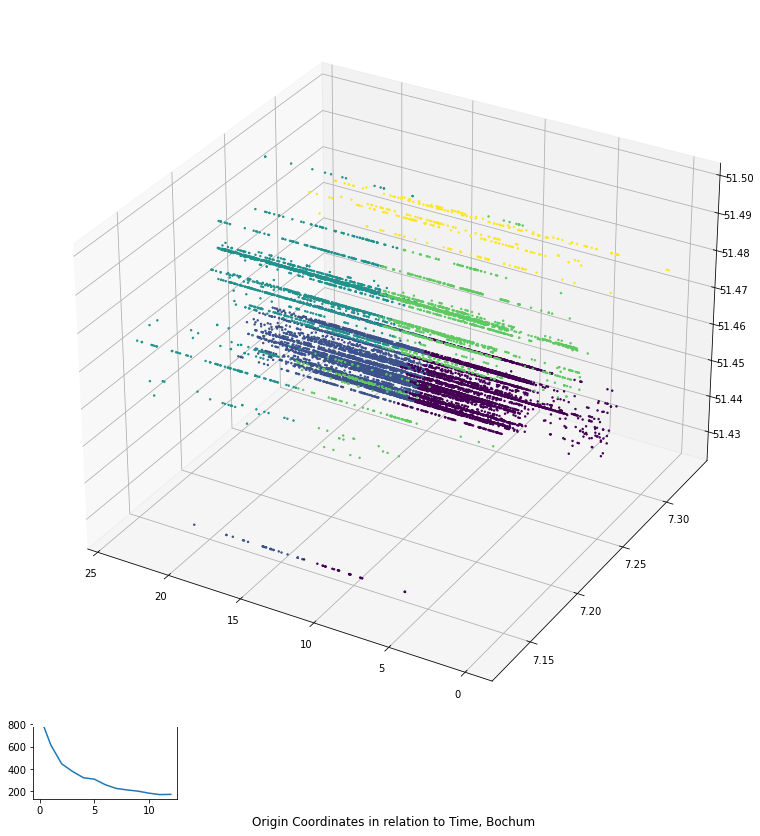

In [199]:
location_clustering_3d(df_clustering_b_work,5,"orig_lng","orig_lat","Origin Coordinates in relation to Time, Bochum")

While this produces clusters in a way, we cannot really see any meaningful cluster points that can be interpreted well. We instead try to work with the distance to the city center in order to produce more meaningful clusters.

In [185]:
def clustering_2d(df,feature1,feature2,n,title):
    fig,ax=plt.subplots(1,3,figsize=(18,6))
    fig.suptitle(title, fontsize=14)
    

    df_clustering = df[[feature1,feature2]]
    df_clustering_n = min_max_scaling(df_clustering)
    
    #L Curve
    ssd = []
    for i in range(2, 15):
        km = KMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)
    ax[1].plot(ssd)
        
    #Fit model 
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)
    
    ax[0].scatter(x=df_clustering[feature1],y=df_clustering[feature2],c=labels,alpha=0.05)
    
    _ = ax[2].hist2d(df_clustering[feature1],
                df_clustering[feature2],
                bins=59,cmap="Blues", 
               )
    
    ax[0].set_title("Clusters")
    ax[1].set_title("L_Curve")
    ax[2].set_title("Histogram")
    
    ax[0].set_ylabel(feature2)
    ax[0].set_xlabel(feature1)
    
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("k")
    
    ax[2].set_ylabel(feature2)
    ax[2].set_xlabel(feature1)

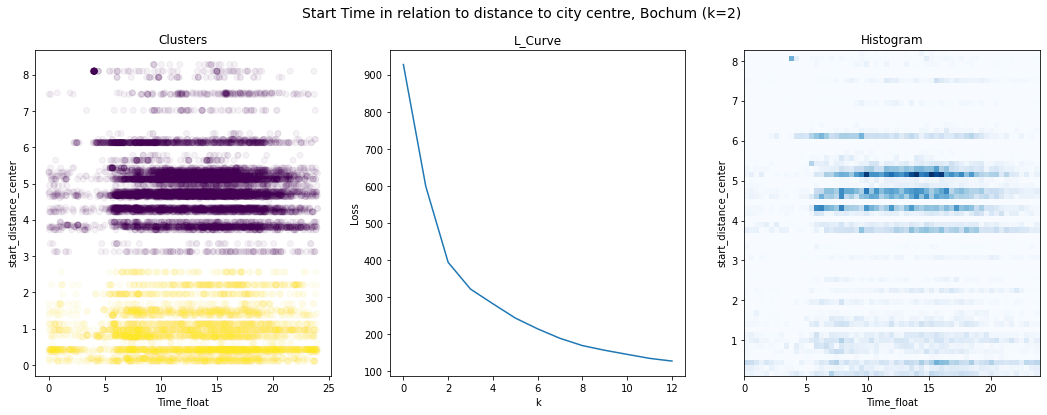

In [189]:
clustering_2d(df_clustering_b,"Time_float","start_distance_center",2,"Start Time in relation to distance to city centre, Bochum (k=2)")

plt.savefig('./Exports/Clustering/time_startdistance_bochum.png', bbox_inches='tight')

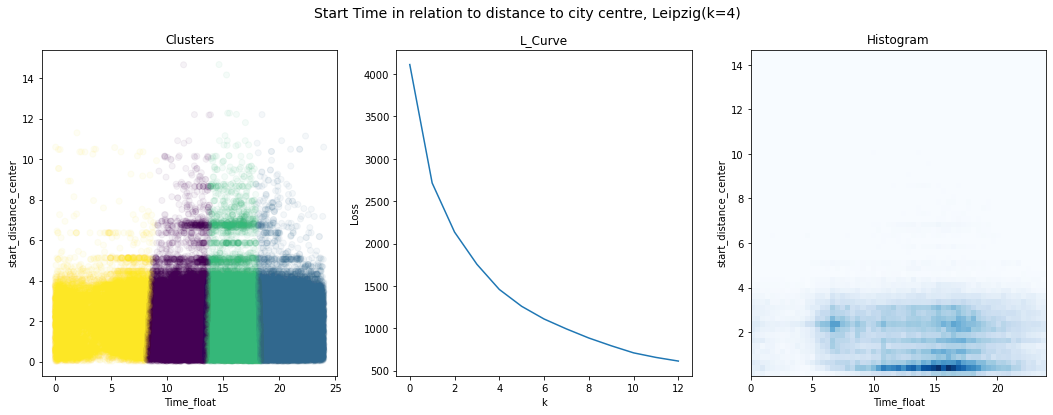

In [190]:
clustering_2d(df_clustering_l,"Time_float","start_distance_center",4,"Start Time in relation to distance to city centre, Leipzig(k=4)")

plt.savefig('./Exports/Clustering/time_startdistance_leipzig.png', bbox_inches='tight')

## Trip Type Clustering

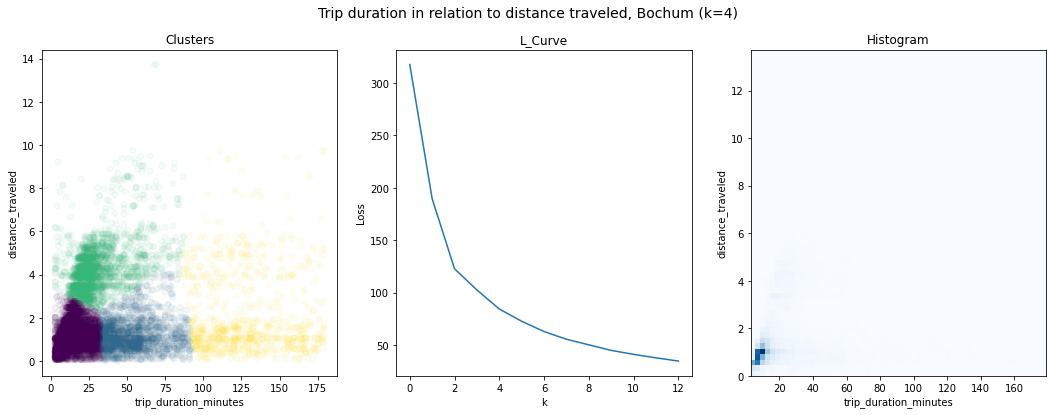

In [200]:
clustering_2d(df_clustering_b,"trip_duration_minutes","distance_traveled",4,"Trip duration in relation to distance traveled, Bochum (k=4)")

plt.savefig('./Exports/Clustering/duration_distance_bochum.png', bbox_inches='tight')

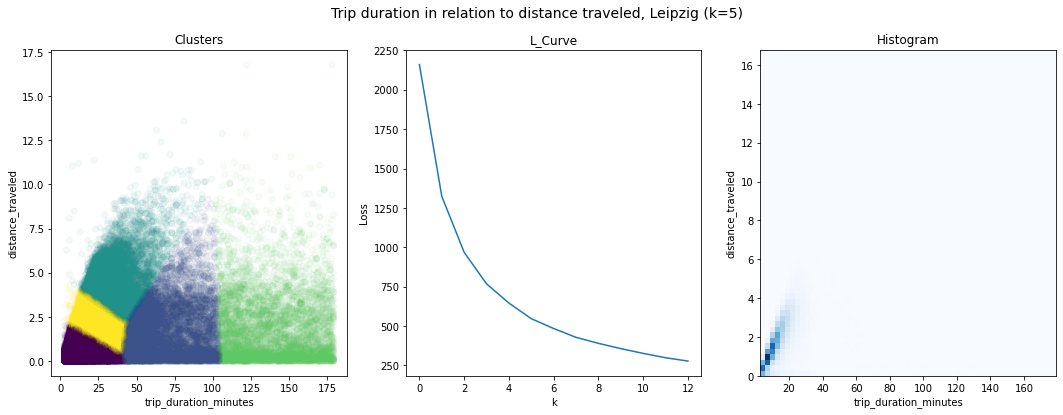

In [192]:
clustering_2d(df_clustering_l,"trip_duration_minutes","distance_traveled",5,"Trip duration in relation to distance traveled, Leipzig (k=5)")

plt.savefig('./Exports/Clustering/duration_distance_leipzig.png', bbox_inches='tight')

# Predictive Analytics

## 4.1 Data Preparation
In this step, we need to add weather data to our existing features. While the DWD offers a lot of raw data, it is difficult to find daily weather data for our specific cities and would involve a lot of processing. We find that using data from meteostat makes this a lot easier as the processing is already done.

In [45]:
#Meteostat Data read-in
meteostat_l = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_l.index = dates
meteostat_l.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_b = pd.read_csv("./weather-data/meteostat-bochum.csv") 
meteostat_b.index = dates
meteostat_b.drop(columns=["wpgt","wdir","date"],inplace=True)

### 4.1.1 Comparison of Meteostat to DWD precipitation Data
The DWD offers rasterised daily precipitation for raster points throughout Germany. However, this data is in an uncommon format and had to be processed with a customised Python script. The code below shows that the precipitation data unconveniently gathered strongly resembles the data that we got from meteostat. We derive that Meteostat has accurate weather data that we can use in our predictive analytics.

C:\Users\Leon\anaconda3\envs\aa\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 0.98, 'Comparison of DWD to Meteostat Data')

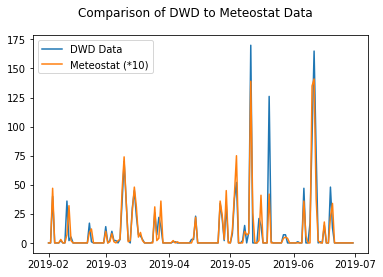

In [46]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

#meteostat_leipzig.isnull().sum().sort_values(ascending=False)

plt.plot(rain_data.index,rain_data.VAL,label="DWD Data")
plt.plot(meteostat_l.index,meteostat_l.prcp*10, label="Meteostat (*10)")
plt.legend()
plt.suptitle("Comparison of DWD to Meteostat Data")

### 4.1.2 Building DataFrame

In [48]:
def df_predictive(df,meteostat):
    df["free_dummy"] = df["free"].astype(int)
    df = df.join(meteostat)
    df = df.drop(columns={"snow","free","daily_usage","weekday","daily_avg_length","weekly_trips","weekly_relative_trips","daily_revenue","daily_used_bikes"})
    return df

df_predictive_l = df_predictive(df_date_l,meteostat_l)
df_predictive_b = df_predictive(df_date_b,meteostat_b)

## 4.2 Feature Selection
For regression problems, it is a good idea to minimise features by finding features that essentially mean the same thing. In this case, we find that we can eliminate the minimum temperature and maximum temperature as they are highly correlated with the average temperature, which obviously makes sense. In other cases, there is a high correlation between e.g. the fleet size and the the average temperature in Leipzig - this is very likely due to the fleet size being scaled up in the same time as temperatures rose. But from human intuition, it is not very plausible that these two things are connected. So we don't eliminate further.

Text(0.5, 1.0, 'Bochum')

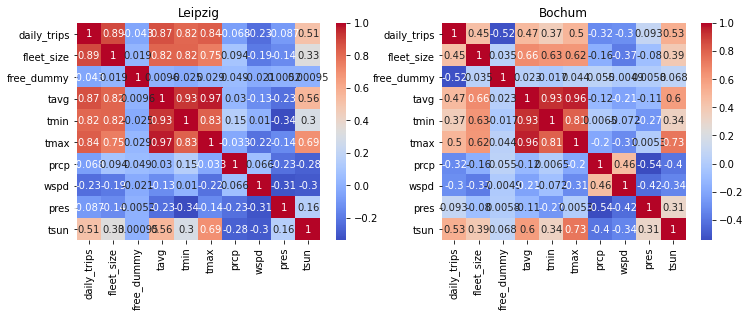

In [49]:
fig,ax  = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm",ax=ax[0])
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="coolwarm",ax=ax[1])

ax[0].set_title("Leipzig")
ax[1].set_title("Bochum")

#plt.savefig('./Exports/Predictive/Correlation_Analysis_before.png', bbox_inches='tight')

Text(0.5, 1.0, 'Bochum')

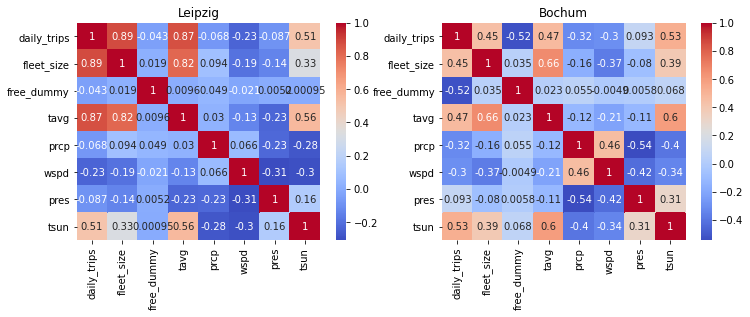

In [50]:
df_predictive_l = df_predictive_l.drop(columns=["tmin","tmax"])
df_predictive_b = df_predictive_b.drop(columns=["tmin","tmax"])

fig,ax  = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm",ax=ax[0])
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="coolwarm",ax=ax[1])

ax[0].set_title("Leipzig")
ax[1].set_title("Bochum")

#plt.savefig('./Exports/Predictive/Correlation_Analysis_after.png', bbox_inches='tight')

## 4.3 Cross-validation splitting

In [51]:
X_b = df_predictive_b.drop(columns=["daily_trips"])
Y_b = df_predictive_b[["daily_trips"]]

X_b_n =  min_max_scaling(X_b)



X_l = df_predictive_l.drop(columns=["daily_trips"])
Y_l = df_predictive_l[["daily_trips"]]

X_l_n =  min_max_scaling(X_l)

X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(X_b_n, Y_b,test_size = 0.3)
X_l_train, X_l_test, Y_l_train, Y_l_test = train_test_split(X_l_n, Y_l,test_size = 0.3)

## 4.4 Fitting models

{'l_tree': 0.8321173938906365,
 'b_tree': 0.4007189036742761,
 'l_mr': 0.8541707163254186,
 'b_mr': 0.5874892503261926}

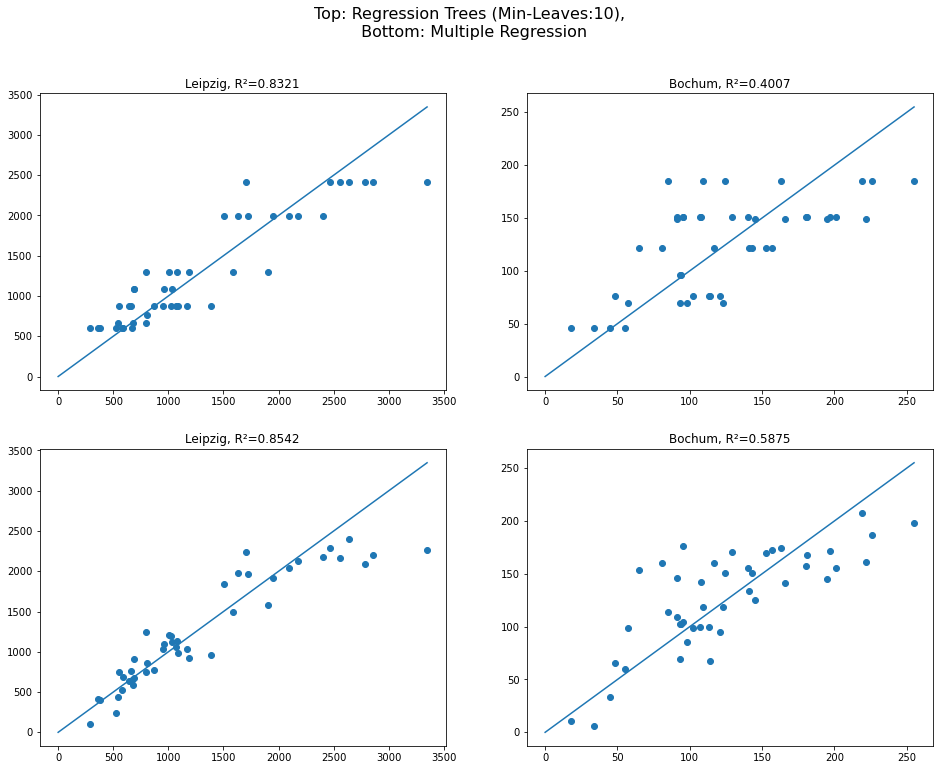

In [55]:
def tree_regression(Xtrain, Ytrain,Xtest, Ytest, min_leaves):
    Tree_reg = DecisionTreeRegressor(min_samples_leaf=min_leaves,criterion="mse")
    Tree_reg.fit(Xtrain, Ytrain)
    Y_pred = Tree_reg.predict(Xtest)
    return Y_pred

def multiple_regression(Xtrain, Ytrain,Xtest, Ytest):
    lin_reg_mod = LinearRegression(normalize=True)
    lin_reg_mod.fit(Xtrain, Ytrain)
    Y_pred = lin_reg_mod.predict(Xtest)
    return Y_pred


def do_regressions(plot):

    Y_l_tree_pred = tree_regression(Xtrain = X_l_train, 
                             Ytrain = Y_l_train,
                             Xtest = X_l_test,
                             Ytest =  Y_l_test, 
                             min_leaves = 10)

    r2_l_tree = r2_score(Y_l_test, Y_l_tree_pred)


    Y_b_tree_pred = tree_regression(Xtrain = X_b_train, 
                             Ytrain = Y_b_train,
                             Xtest = X_b_test,
                             Ytest =  Y_b_test, 
                             min_leaves = 10)

    r2_b_tree = r2_score(Y_b_test, Y_b_tree_pred)


    Y_l_mr_pred = multiple_regression(Xtrain = X_l_train, 
                             Ytrain = Y_l_train,
                             Xtest = X_l_test,
                             Ytest =  Y_l_test)

    r2_l_mr = r2_score(Y_l_test, Y_l_mr_pred)


    Y_b_mr_pred = multiple_regression(Xtrain = X_b_train, 
                             Ytrain = Y_b_train,
                             Xtest = X_b_test,
                             Ytest =  Y_b_test)

    r2_b_mr = r2_score(Y_b_test, Y_b_mr_pred)

    if plot:
        fig, axes = plt.subplots(2,2,figsize = (16,12))
        fig.suptitle("Top: Regression Trees (Min-Leaves:10), \n Bottom: Multiple Regression",fontsize=16)

    
        axes[0,0].scatter(Y_l_test, Y_l_tree_pred)
        axes[0,0].set_title("Leipzig, R²="+str(round(r2_l_tree,4)))
        max=Y_l_test.max()["daily_trips"]
        x = np.linspace(0, max,max)
        axes[0,0].plot(x,x)

        axes[0,1].scatter(Y_b_test, Y_b_tree_pred)
        axes[0,1].set_title("Bochum, R²="+str(round(r2_b_tree,4)))
        max=Y_b_test.max()["daily_trips"]
        x = np.linspace(0, max,max)
        axes[0,1].plot(x,x)

        axes[1,0].scatter(Y_l_test, Y_l_mr_pred)
        axes[1,0].set_title("Leipzig, R²="+str(round(r2_l_mr,4)))
        max=Y_l_test.max()["daily_trips"]
        x = np.linspace(0, max,max)
        axes[1,0].plot(x,x)

        axes[1,1].scatter(Y_b_test, Y_b_mr_pred)
        axes[1,1].set_title("Bochum, R²="+str(round(r2_b_mr,4)))
        max=Y_b_test.max()["daily_trips"]
        x = np.linspace(0, max,max)
        axes[1,1].plot(x,x)
    
    
    return {"l_tree":r2_l_tree,"b_tree": r2_b_tree,"l_mr": r2_l_mr,"b_mr": r2_b_mr}
do_regressions(plot=True)

## 4.5 Assessing Model Performance

(0.0, 1.0)

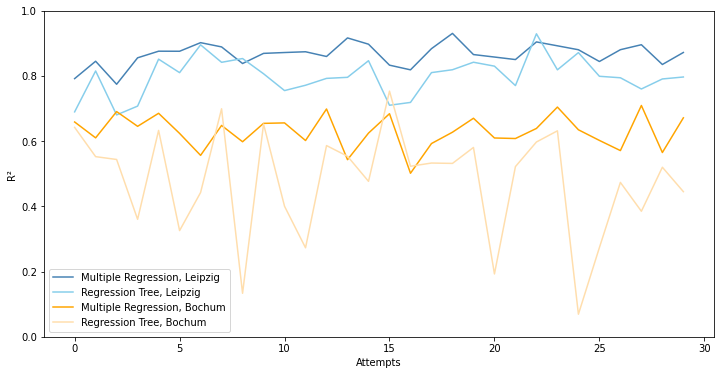

In [56]:
from IPython.display import clear_output
i = 0
r2s = []
while i < 30:

    X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(X_b_n, Y_b,test_size = 0.3)
    X_l_train, X_l_test, Y_l_train, Y_l_test = train_test_split(X_l_n, Y_l,test_size = 0.3)            
    
    r2s.append(do_regressions(plot=False))
    i=i+1
    clear_output()
r2s=pd.DataFrame(r2s)

fig,ax = plt.subplots(figsize = (12,6))
ax.plot(r2s.index,r2s["l_mr"],c="steelblue",label="Multiple Regression, Leipzig")
ax.plot(r2s.index,r2s["l_tree"],c="skyblue",label="Regression Tree, Leipzig")
ax.plot(r2s.index,r2s["b_mr"],c="orange",label="Multiple Regression, Bochum")
ax.plot(r2s.index,r2s["b_tree"],c="navajowhite",label="Regression Tree, Bochum")

ax.legend()
ax.set_ylabel("R²")
ax.set_xlabel("Attempts")
ax.set_ylim(0,1)

### ARIMA Prediction Model

In [236]:
df_arima_l = df_kpi_l[["daily_trips"]]
df_arima_b = df_kpi_b[["daily_trips"]]